# BE/Bi 103, Fall 2015: Homework 6

## Due 1pm, Monday, November 16

*This document was generated from a Jupyter notebook.  You can download the notebook [here](hw6.ipynb).*


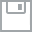
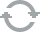
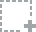
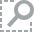
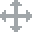
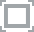
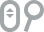
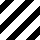
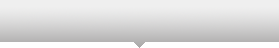
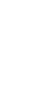
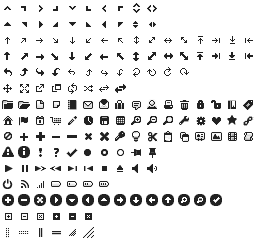
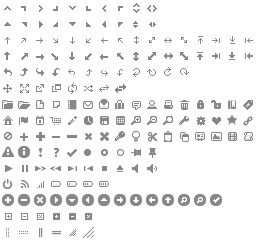
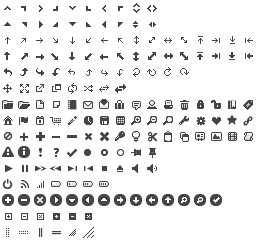
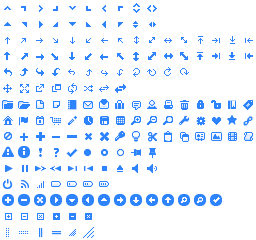
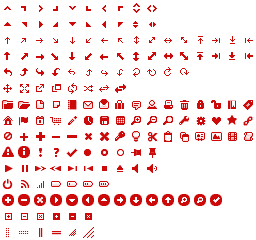
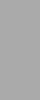
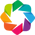
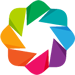

In [19]:
import itertools
import pickle
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.misc
import scipy.stats as st
import scipy.special

# The MCMC Hammer
import emcee

# Numba for speed
import numba

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem 6.1: Microtubule catastrophe, 70 pts + 15 pts extra credit

In [Homework 1](hw1.html), we plotted data of microtubule catastrophe times.  In this problem, we return to the data from the [Gardner, Zanic, et al. paper](../protected/papers/gardner_2011.pdf)  We will carefully analyze the data and make some conclusions about the processes underlying microtubule catastrophe.  You can download the data set [here](../protected/data/gardner_hw6.zip).

In the file `gardner_mt_catastrophe_only_tubulin.csv`, we have observed catastrophe times of microtubules with different concentrations of tubulin.  So, our data set $D$ consists of a set of measurements of the amount of time to catastrophe; $D = \{t_i\}$.  To model microtuble catastrophe, we will assume that a series of $m$,  processes must occur sequentially to trigger catastrophe.  This could be separate depolymerization events, binding of auxiliary proteins, etc.  We assume that each of these processes is a Poisson process, and that process $j$ occurs with rate $1/\tau_j$.  Our goal here is to do model selection to determine the value of $m$.

As we have learned, the model specifies the likelihood.  We will assume all microtubule catastrophes are independent, so the likelihood for all of our observed catastrophes 

\begin{align}
P(D\mid \boldsymbol{\tau}, m, I) = \prod_i P(t_i\mid \boldsymbol{\tau}, m, I).
\end{align}

**a)** Explain why the probability distribution for catastrophe times for a three-step process ($m=3$) is

\begin{align}
P(t\mid \tau_1, \tau_2, \tau_3, 3, I) = \frac{1}{\tau_1\tau_2\tau_3}\int_0^t\mathrm{d}t_1 \int_{t_1}^t\mathrm{d}t_2\, \mathrm{e}^{-t_1/\tau_1}\,\mathrm{e}^{-(t_2-t_1)/\tau_2}\,\mathrm{e}^{-(t-t_2)/\tau_3}.
\end{align}

**b)** The above expression for general $m$ can be integrated, giving

\begin{align}
P(t\mid \boldsymbol{\tau}, m, I) = \sum_{j=1}^m \frac{\tau_j^{m-2}\,\mathrm{e}^{-t/\tau_j}}{\prod_{k=1,k\ne j}^m (\tau_j - \tau_k)}.
\end{align}

For clarity, the probability distributions for the first few $m$ are

\begin{align}
P(t\mid \tau_1, 1, I) &= \frac{\mathrm{e}^{-t/\tau_1}}{\tau_1},\\[1em]
P(t\mid \tau_1, \tau_2, 2, I) &=
\frac{\mathrm{e}^{-t/\tau_1}}{\tau_1 - \tau_2} + \frac{\mathrm{e}^{-t/\tau_2}}{\tau_2 - \tau_1}
= \frac{\mathrm{e}^{-t/\tau_2} - \mathrm{e}^{-t/\tau_1}}{\tau_2 - \tau_1} \\[1em]
P(t\mid \tau_1, \tau_2, \tau_3, 3, I) &=
\frac{\tau_1\,\mathrm{e}^{-t/\tau_1}}{(\tau_1 - \tau_2)(\tau_1-\tau_3)}
+\frac{\tau_2\,\mathrm{e}^{-t/\tau_2}}{(\tau_2 - \tau_1)(\tau_2-\tau_3)}
+\frac{\tau_3\,\mathrm{e}^{-t/\tau_3}}{(\tau_3 - \tau_1)(\tau_3-\tau_2)}
\end{align}

Note that these probability distributions assume that no two of the $\tau_j$'s are equal, and you should explicitly ensure this in your calculations.  If any two $\tau_j$'s are equal, you need to take a limit, e.g.,

\begin{align}
\lim_{\tau_2\to\tau_1} P(t\mid \tau_1, \tau_2, 2, I) &= \frac{t^2}{2\tau_1}\,\mathrm{e}^{-t/\tau_1},
\end{align}

in this case, as gamma distribution.  Not to worry; we will not include this limit in our analysis here.

In fact, you should specify $\tau_1 < \tau_2 < \cdots < \tau_n$.  Why is this ok to do, and why should you do it?

**c)** For the trials where the tubulin concentration is 12 µM (from the file `gardner_mt_catastrophe_only_tubulin.csv`), perform parameter estimation for the $\{\tau_j\}$ and model selection for various values of $m$.  Report the results with clear graphics and discussion.  

*Hint*: Computing the log of the sum of exponentials while dealing with machine precision is a tricky business, and something that comes up often in probability.  Here is my advice.  Say you are computing $\ln(\mathrm{e}^a - \mathrm{e}^b + \mathrm{e}^c)$ with $a>b>c$.  We have

\begin{align}
\ln(\mathrm{e}^a - \mathrm{e}^b + \mathrm{e}^c) = \ln\left(\mathrm{e}^a(1 - \mathrm{e}^{b-a} + \mathrm{e}^{c-a})\right)
= a + \ln(1 - \mathrm{e}^{b-a} + \mathrm{e}^{c-a}).
\end{align}

This latter expression is much easier to compute numerically because all entries in the sum inside the logarithm at less than or equal to one, given that $a$ is the largest argument to the exponentials.

**d)** Using whichever model you found most probable when you computed the odds ratio for the 12 µM tubulin measurements, the values of the $\tau_j$'s for the other concentrations of tubulin.  Given that microtubules polymerize faster with higher tubulin concentrations, is there anything you can say about the occurrence of catastrophe by looking at the values of the $\tau_j$'s versus tubulin concentration?

**e) (15 points extra credit)** In the files `gardner_mt_catastrophe_kip3.csv` and `gardner_mt_catastrophe_mcak.csv`, there are measurements of catastrophe times in the presence of the kinesins Kip3 and MCAK with 12 µM tubulin.  Analyze these data and discuss conclusions about their respective roles in microtubule catastrophe.  *Note*: This part of the problem is intentionally open-ended.  You should think carefully, and perform a complete analysis to draw your conclusions.

### Problem 6.1: solution

**a)** To be added.

**b)** If we order the $\tau_j$'s, we can write

\begin{align}
P(t\mid \boldsymbol{\tau}, m, I) = \sum_{j=1}^m (-1)^{m-j}\,\frac{\tau_j^{m-2}\,\mathrm{e}^{-t/\tau_j}}{\prod_{k=1,k\ne j}^m \left|\tau_j - \tau_k\right|}.
\end{align}

This enables us to write the sum as

\begin{align}
P(t\mid \boldsymbol{\tau}, m, I)  = \sum_{j=1}^m (-1)^{m-j}\, \exp\left\{-\frac{t}{\tau_j} + (m-2) \ln \tau_j - \sum_{k=1,k\ne j}^m \ln\left|\tau_j-\tau_k\right|\right\}.
\end{align}

The likelihood is then

\begin{align}
P(D\mid \boldsymbol{\tau}, m, I) = \prod_i\left(
\sum_{j=1}^m (-1)^{m-j}\, \exp\left\{-\frac{t_i}{\tau_j} + (m-2) \ln \tau_j - \sum_{k=1,k\ne j}^m \ln\left|\tau_j-\tau_k\right|\right\}
\right),
\end{align}

giving a log likelihood of

\begin{align}
\ln P(D\mid \boldsymbol{\tau}, m, I) = \sum_i \ln\left(\sum_{j=1}^m (-1)^{m-j}\, \exp\left\{-\frac{t_i}{\tau_j} + (m-2) \ln \tau_j - \sum_{k=1,k\ne j}^m \ln\left|\tau_j-\tau_k\right|\right\}\right).
\end{align}

**c)** First, let's load in the data, tidy it, and extract our times of interest.

In [2]:
# Load the data set
fname = '../data/gardner_et_al/gardner_mt_catastrophe_only_tubulin.csv'
df = pd.read_csv(fname, comment='#')

# Tidy the DataFrame
df = pd.melt(df, var_name='tubulin conc (µM)', 
             value_name='time to catastrophe (s)')
df = df.dropna()

# Convert concentrations from string to numbers
df['tubulin conc (µM)'] = \
        df['tubulin conc (µM)'].str.extract('(\d+)').astype(int)

# Pull our t, and have it sorted for convenience
t = df[df['tubulin conc (µM)']==12]['time to catastrophe (s)'].values
t.sort()

Now let's plot an ECDF just so we can see what we're dealing with.

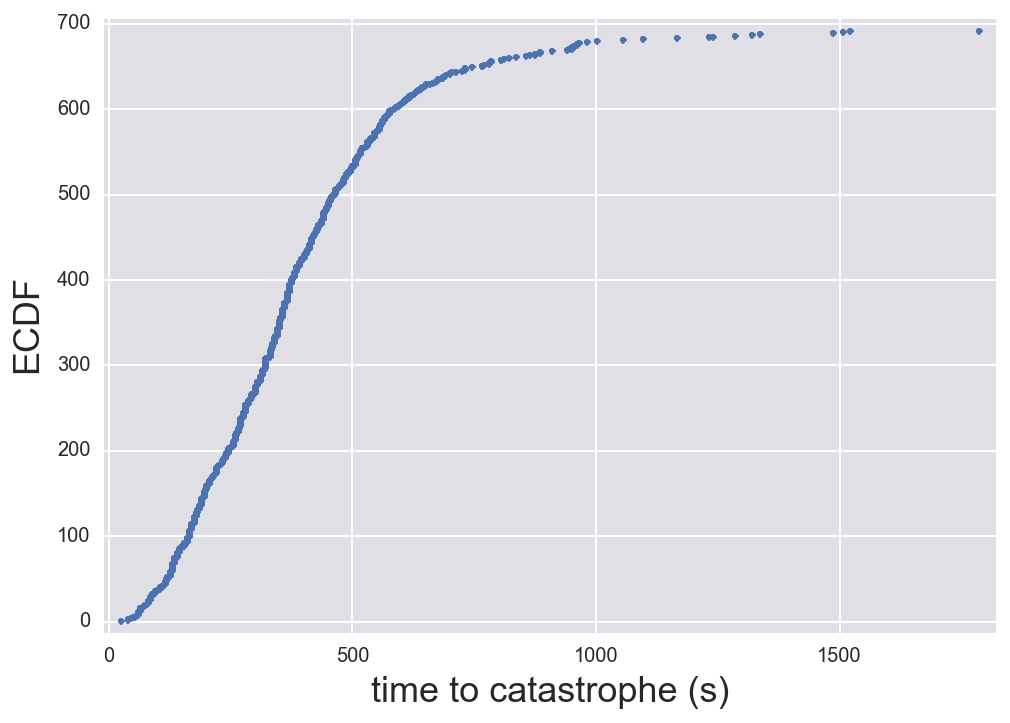

In [3]:
# Construct ECDF
y = np.arange(1, len(t) + 1)
plt.plot(t, y, '.')
plt.xlabel('time to catastrophe (s)')
plt.ylabel('ECDF')
plt.margins(0.02)

Now, we'll define our log likelihood.  Importantly, we need to use the logsumexp trick to compute the log of the sum of exponentials.  Otherwise, we will run into trouble with underflow.

In [4]:
def log_likelihood(tau, t):
    """
    Log likelihood using sp.misc.logsumexp()
    """
    # Number of data points
    n = len(t)
    
    # Number of Poisson processes
    m = len(tau)
    
    # Compute special case first
    if m == 1:
        return -n * np.log(tau[0]) - t.sum() / tau[0]
    else:
        # Scale for logsumexp
        b = np.empty((1, m), dtype=int)
        if (m % 2) == 0:
            b[0,::2] = -1
            b[0,1::2] = 1
        else:
            b[0,::2] = 1
            b[0,1::2] = -1    

        # Set up arguments of exponentials in sum
        exp_args = np.empty((n, m), dtype=np.float)
        for j, tau_j in enumerate(tau):
            sum_logs = np.sum(np.log(np.abs(tau[:j] - tau[j]))) \
                            + np.sum(np.log(np.abs(tau[j+1:] - tau[j])))
            exp_args[:,j] = -t / tau_j + (m - 2) * np.log(tau_j) - sum_logs

        return scipy.misc.logsumexp(exp_args, b=b, axis=1).sum()

The log likelihood is a complicated function.  It is generally a good idea with any function, especially a complicated one, to test it for simple test cases.  We'll therefore write a testing function that works for $m \in \{1,2,3,4\}$.  The test function does not explicitly deal with the precision issues, but if we choose the right $\tau$'s, it will work.

In [10]:
def test_log_likelihood(tau, t):
    """
    Check log likelihood function for first few values of m
    """
    # Number of data points
    n = len(t)
        
    # Number of Poisson processes
    m = len(tau)
    
    # Compute log likelihood for special cases
    if m == 1:
        log_like = -n * np.log(tau[0]) - t.sum() / tau[0]
    
    if m == 2:
        log_like = np.sum(np.log(
                (np.exp(-t/tau[1]) - np.exp(-t/tau[0])) / (tau[1] - tau[0])))
    
    if m == 3:
        log_like = np.sum(np.log(
            np.exp(-t/tau[0]) * tau[0] / (tau[0] - tau[1]) / (tau[0] - tau[2]) \
          + np.exp(-t/tau[1]) * tau[1] / (tau[1] - tau[0]) / (tau[1] - tau[2]) \
          + np.exp(-t/tau[2]) * tau[2] / (tau[2] - tau[0]) / (tau[2] - tau[1])))
    
    if m == 4:
        tau_prods = [(tau[0] - tau[1]) * (tau[0] - tau[2]) * (tau[0] - tau[3]),
                     (tau[1] - tau[0]) * (tau[1] - tau[2]) * (tau[1] - tau[3]),
                     (tau[2] - tau[0]) * (tau[2] - tau[1]) * (tau[2] - tau[3]),
                     (tau[3] - tau[0]) * (tau[3] - tau[1]) * (tau[3] - tau[2])]
        log_like =  np.sum(np.log(
                np.exp(-t/tau[0]) * tau[0]**2 / tau_prods[0] \
              + np.exp(-t/tau[1]) * tau[1]**2 / tau_prods[1] \
              + np.exp(-t/tau[2]) * tau[2]**2 / tau_prods[2] \
              + np.exp(-t/tau[3]) * tau[3]**2 / tau_prods[3]))
    
    # Make sure we got the right values
    if np.isfinite(log_like):
        assert np.isclose(log_likelihood(tau, t), log_like)
    else:
        print('Infinite log likelihood test value.')

Now that we have the test function, we can try it for dummy values of `t` and `tau`.  If no `AssertionError` come up, then we know it passed the tests.  We'll generate 20 randome times, and then try 100 random sets of $\tau$'s for each $m$ that we test.

In [11]:
test_t = np.random.uniform(0, 10, 20)

for m in [2, 3, 4]:
    test_tau = np.random.uniform(0, 1, (100, m))
    test_tau = np.sort(test_tau, axis=1)
    for i in range(len(test_tau)):
        test_log_likelihood(test_tau[i,:], test_t)

Success!  Our function works as we expect, so we will go forward using it.

We next need to define the prior.  We need to make sure the $\tau$'s are rank ordered and positive.  If they are, we take a Jeffreys prior for each $\tau$, which we consider to be independent.

In [12]:
def log_prior(tau, tau_min, tau_max, eps=1e-6):
    """
    Log prior for successive Poisson processes model.
    """
    if (tau[0] < tau_min) or (tau[-1] > tau_max) \
                        or (not (np.diff(tau) > eps).all()):
        return -np.inf
    
    return -len(tau) * np.log(np.log(tau_max / tau_min)) - np.log(tau).sum()

So now we have a log likelihood and a log prior.  We just need to get initial conditions for walkers, and we can perform MCMC.

In [13]:
def walker_starting_points(m, n_temps, n_walkers, tau_min, tau_max):
    """
    Generate walker starting positions for PTMCMC
    """
    p0 = np.random.uniform(tau_min, tau_max, (n_temps, n_walkers, m))
    p0 = np.sort(p0, axis=2)
    return p0

Finally, we'll write a function to do the PTMCMC sampling for our model.

In [14]:
def sample_ptmcmc(t, m, tau_min=1, tau_max=2000, n_temps=20, n_walkers=100, 
                  n_burn=100, n_steps=500, threads=None):

    # Starting points of walkers
    p0 = walker_starting_points(m, n_temps, n_walkers, tau_min, tau_max)
    
    # Columns for output DataFrame
    columns = ['tau_' + str(i) + ' (s)' for i in range(1, m+1)]
    
    return bebi103.run_pt_emcee(
        log_likelihood, log_prior, n_burn, n_steps, n_temps=n_temps, p0=p0, 
        loglargs=(t,), logpargs=(tau_min, tau_max), threads=threads, 
        columns=columns, return_lnZ=True)

We'll set up a dictionary for the output.  We'll test up to $m_\mathrm{max} = 6$.

In [15]:
m_max = 6
results = {m: {} for m in range(1, m_max+1)}

Let's first do PTMCMC!

In [35]:
for m in range(1, m_max+1):
    print('Performing MCMC for m =', m, '...', flush=True)
    results[m]['df'], results[m]['ln_Z'], results[m]['dln_Z'] = sample_ptmcmc(
            t, m, tau_min=1, tau_max=2000, n_temps=20, n_walkers=100, 
            n_burn=1000, n_steps=2000, threads=6)

Performing MCMC for m = 1 ...
Performing MCMC for m = 2 ...
Performing MCMC for m = 3 ...
Performing MCMC for m = 4 ...
Performing MCMC for m = 5 ...
Performing MCMC for m = 6 ...


We just spent a whole lot of computational resources to compute the traces, so let's save the results on disk if we want them later.

In [36]:
with open('ptmcmc_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Now that the sampling is done, let's check the odds ratios.

In [37]:
for m in range(2, m_max+1):
    print('O_1{0:d} = {1:.2e}'.format(
            m, np.exp(results[1]['ln_Z'] - results[m]['ln_Z'])))

O_12 = 2.25e-61
O_13 = 5.21e-72
O_14 = 5.30e-72
O_15 = nan
O_16 = nan


We see that either the 3-step or 4-step model are most probable.  One-setp is out of the question.  Let's look at the posteriors.  We'll make each corner plot in a separate cell for clarity.

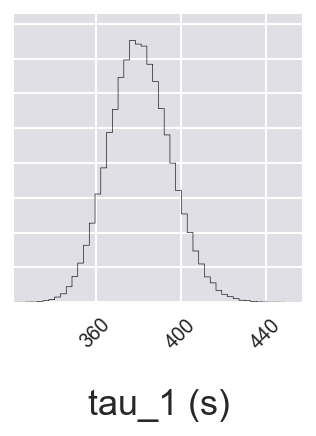

In [38]:
m = 1
df_ = results[m]['df'][results[m]['df'].beta_ind==0].filter(regex='tau')
corner.corner(df_, bins=50);

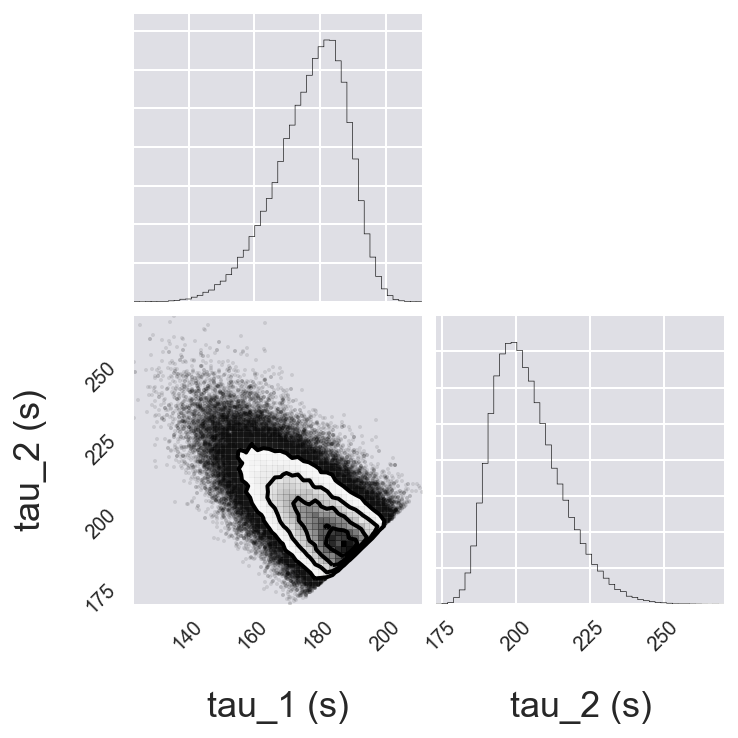

In [39]:
m = 2
df_ = results[m]['df'][results[m]['df'].beta_ind==0].filter(regex='tau')
corner.corner(df_, bins=50);

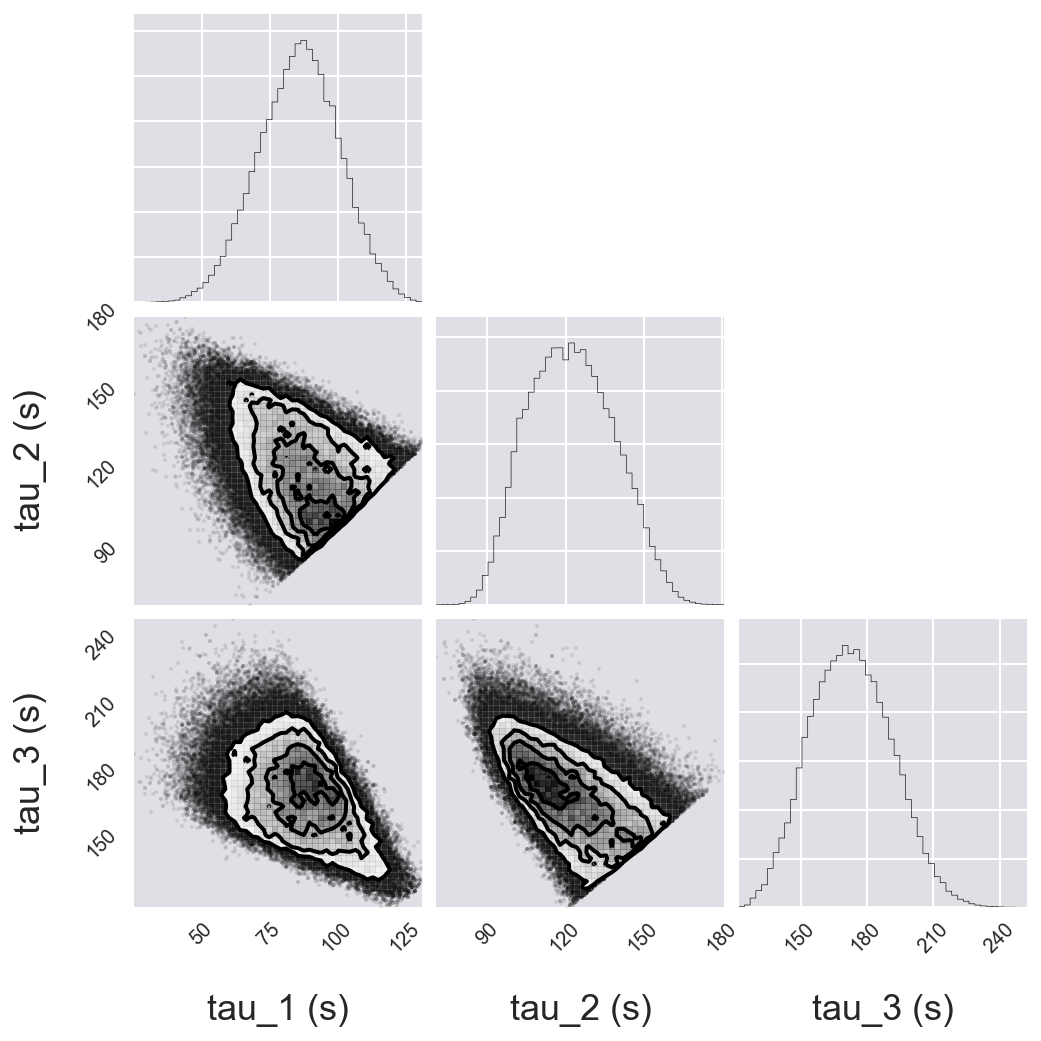

In [40]:
m = 3
df_ = results[m]['df'][results[m]['df'].beta_ind==0].filter(regex='tau')
corner.corner(df_, bins=50);

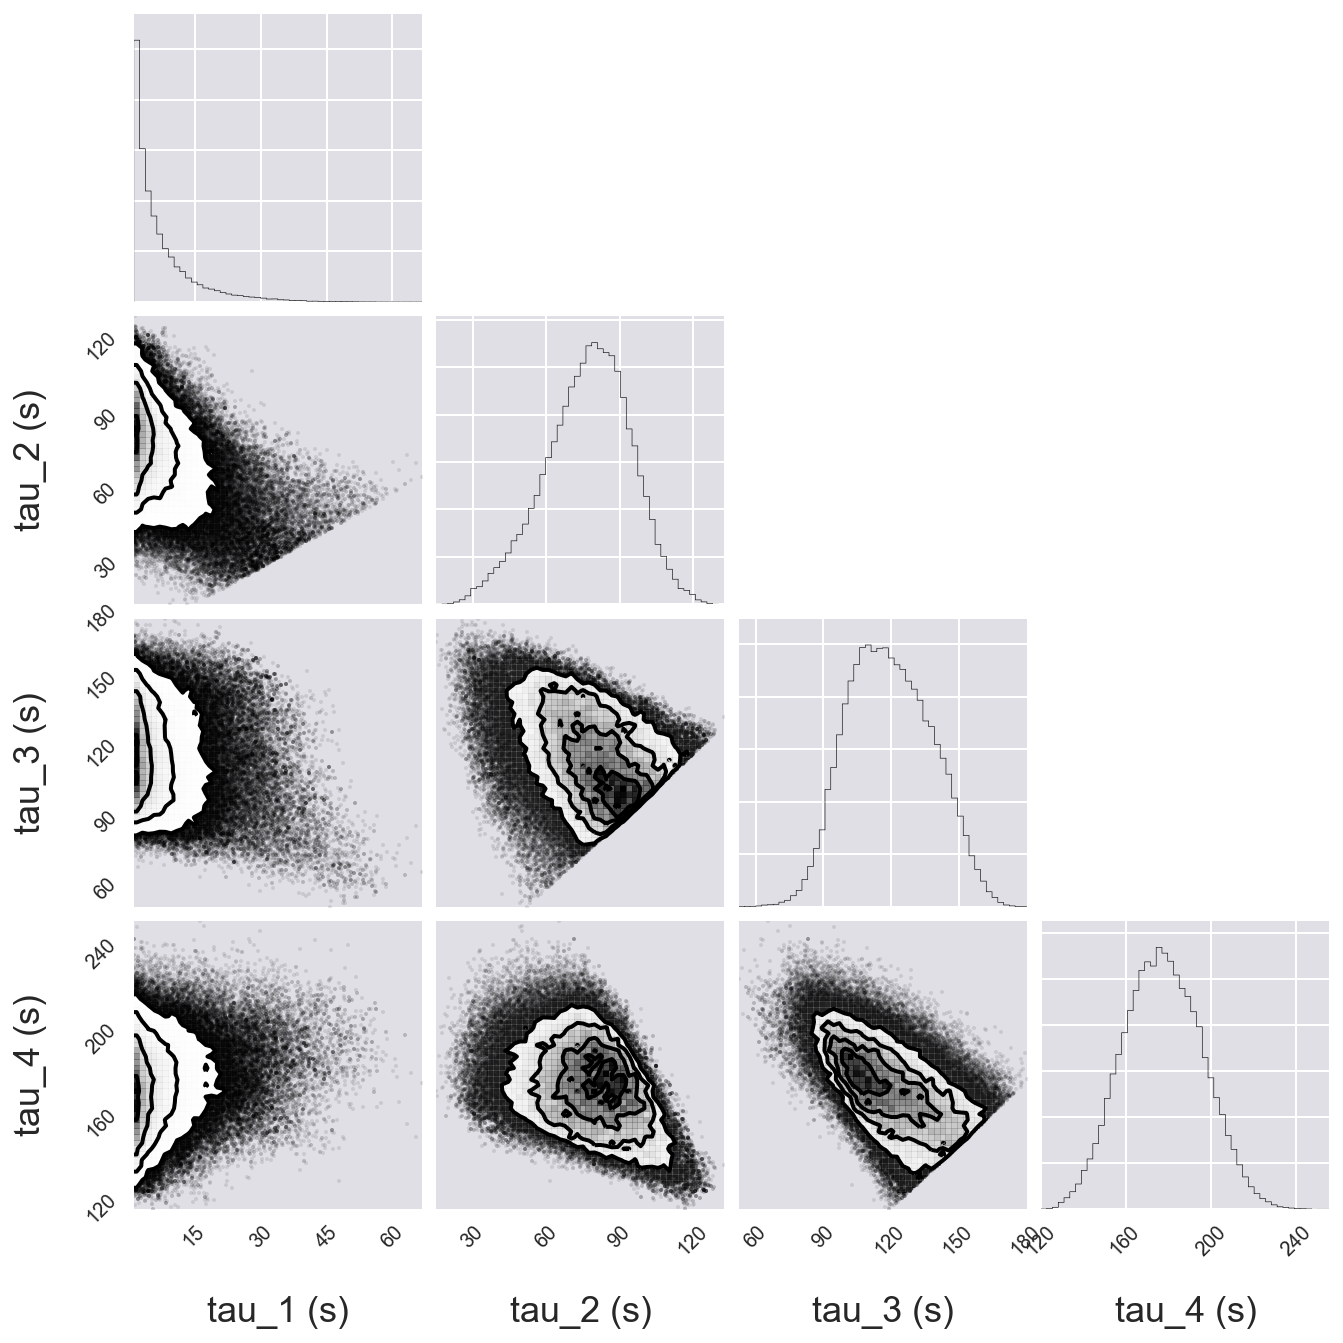

In [41]:
m = 4
df_ = results[m]['df'][results[m]['df'].beta_ind==0].filter(regex='tau')
corner.corner(df_, bins=50);

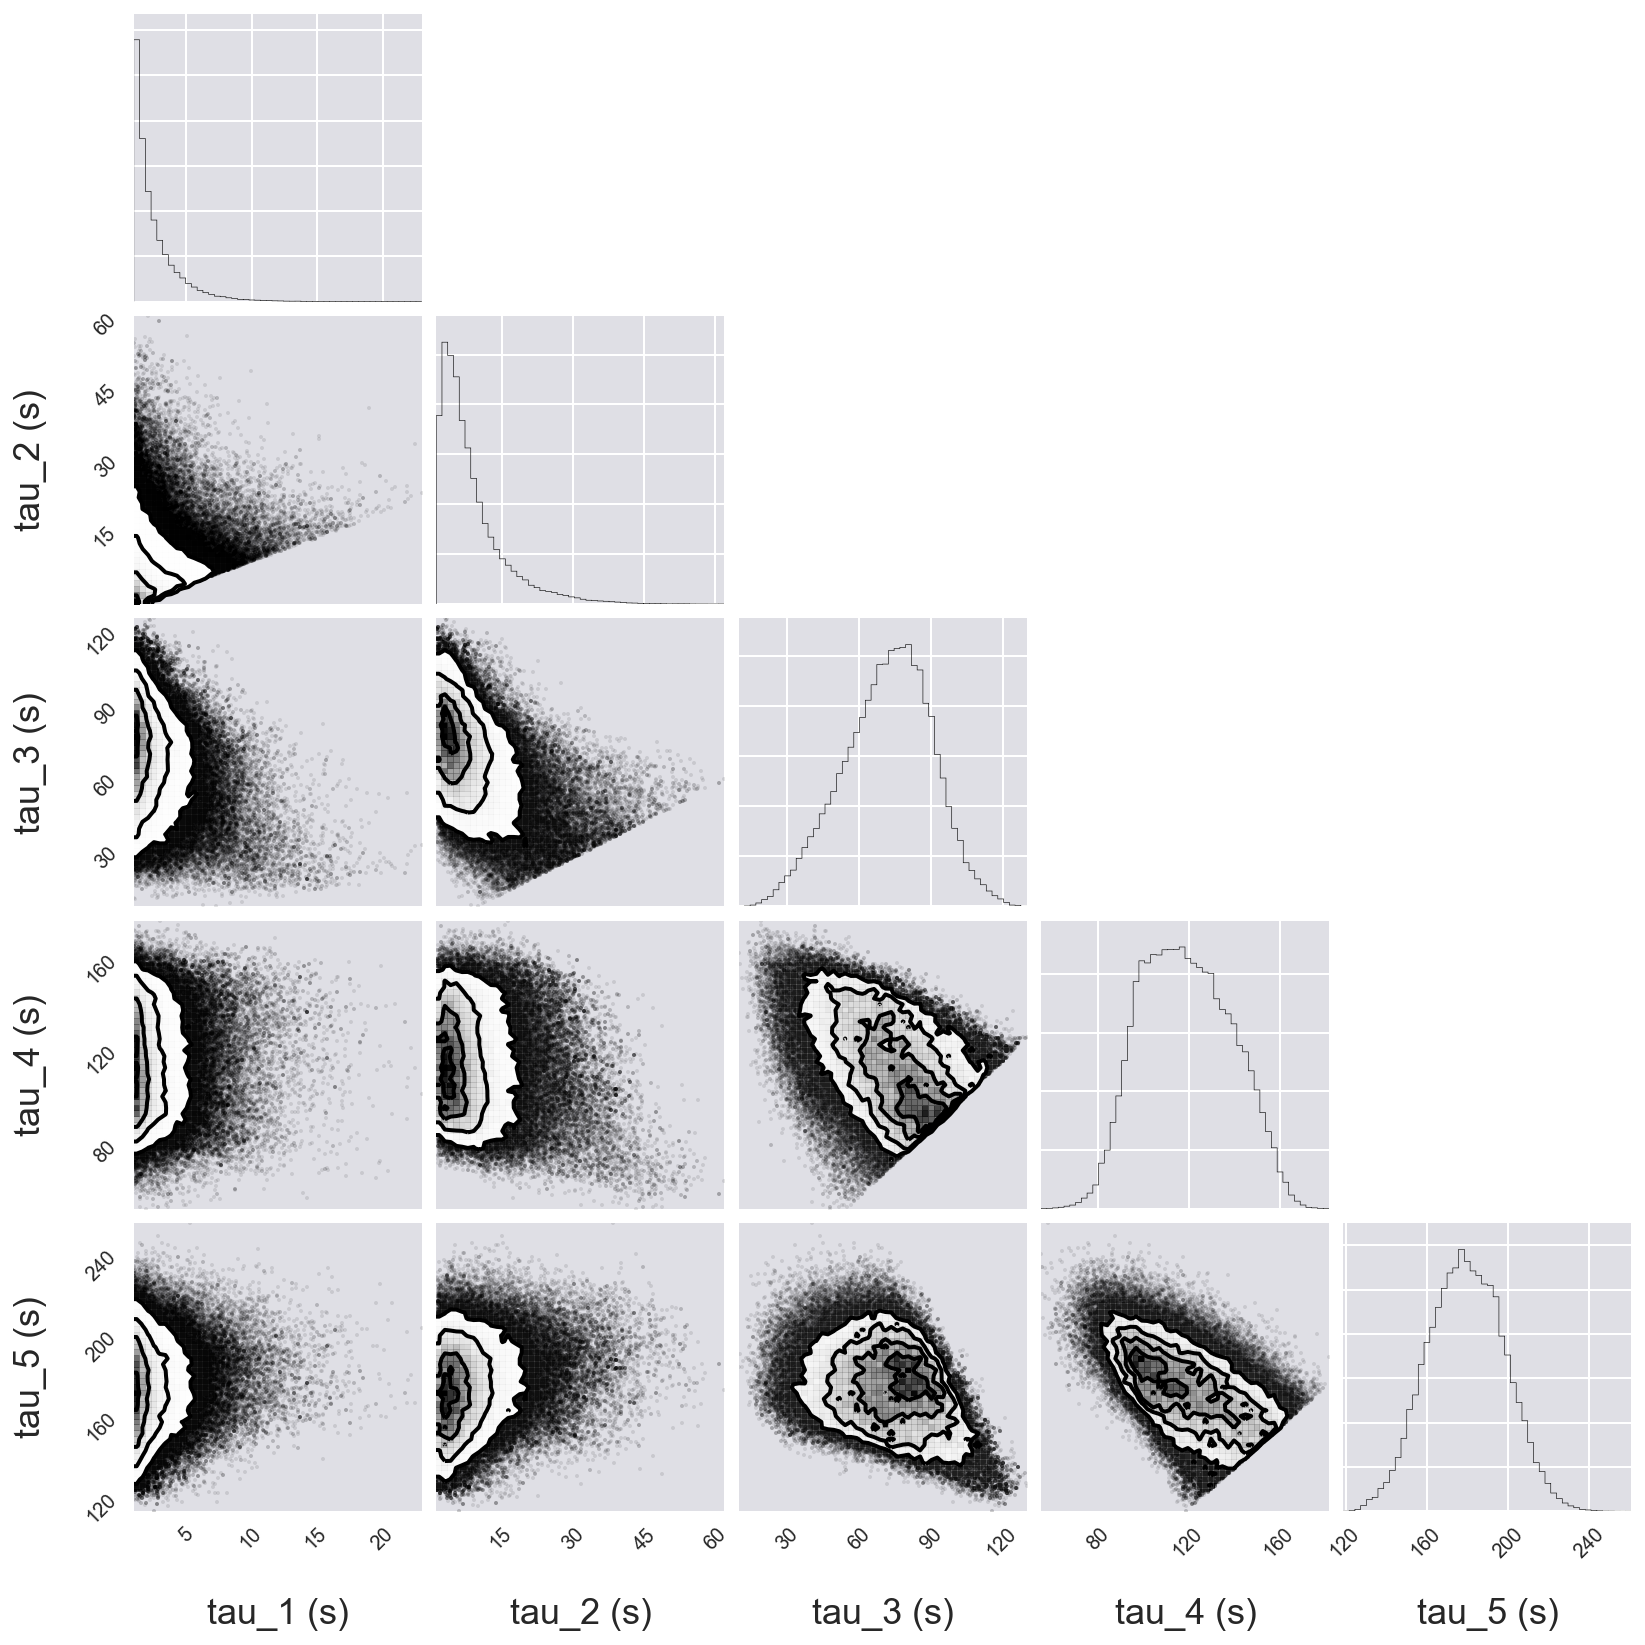

In [42]:
m = 5
df_ = results[m]['df'][results[m]['df'].beta_ind==0].filter(regex='tau')
corner.corner(df_, bins=50);

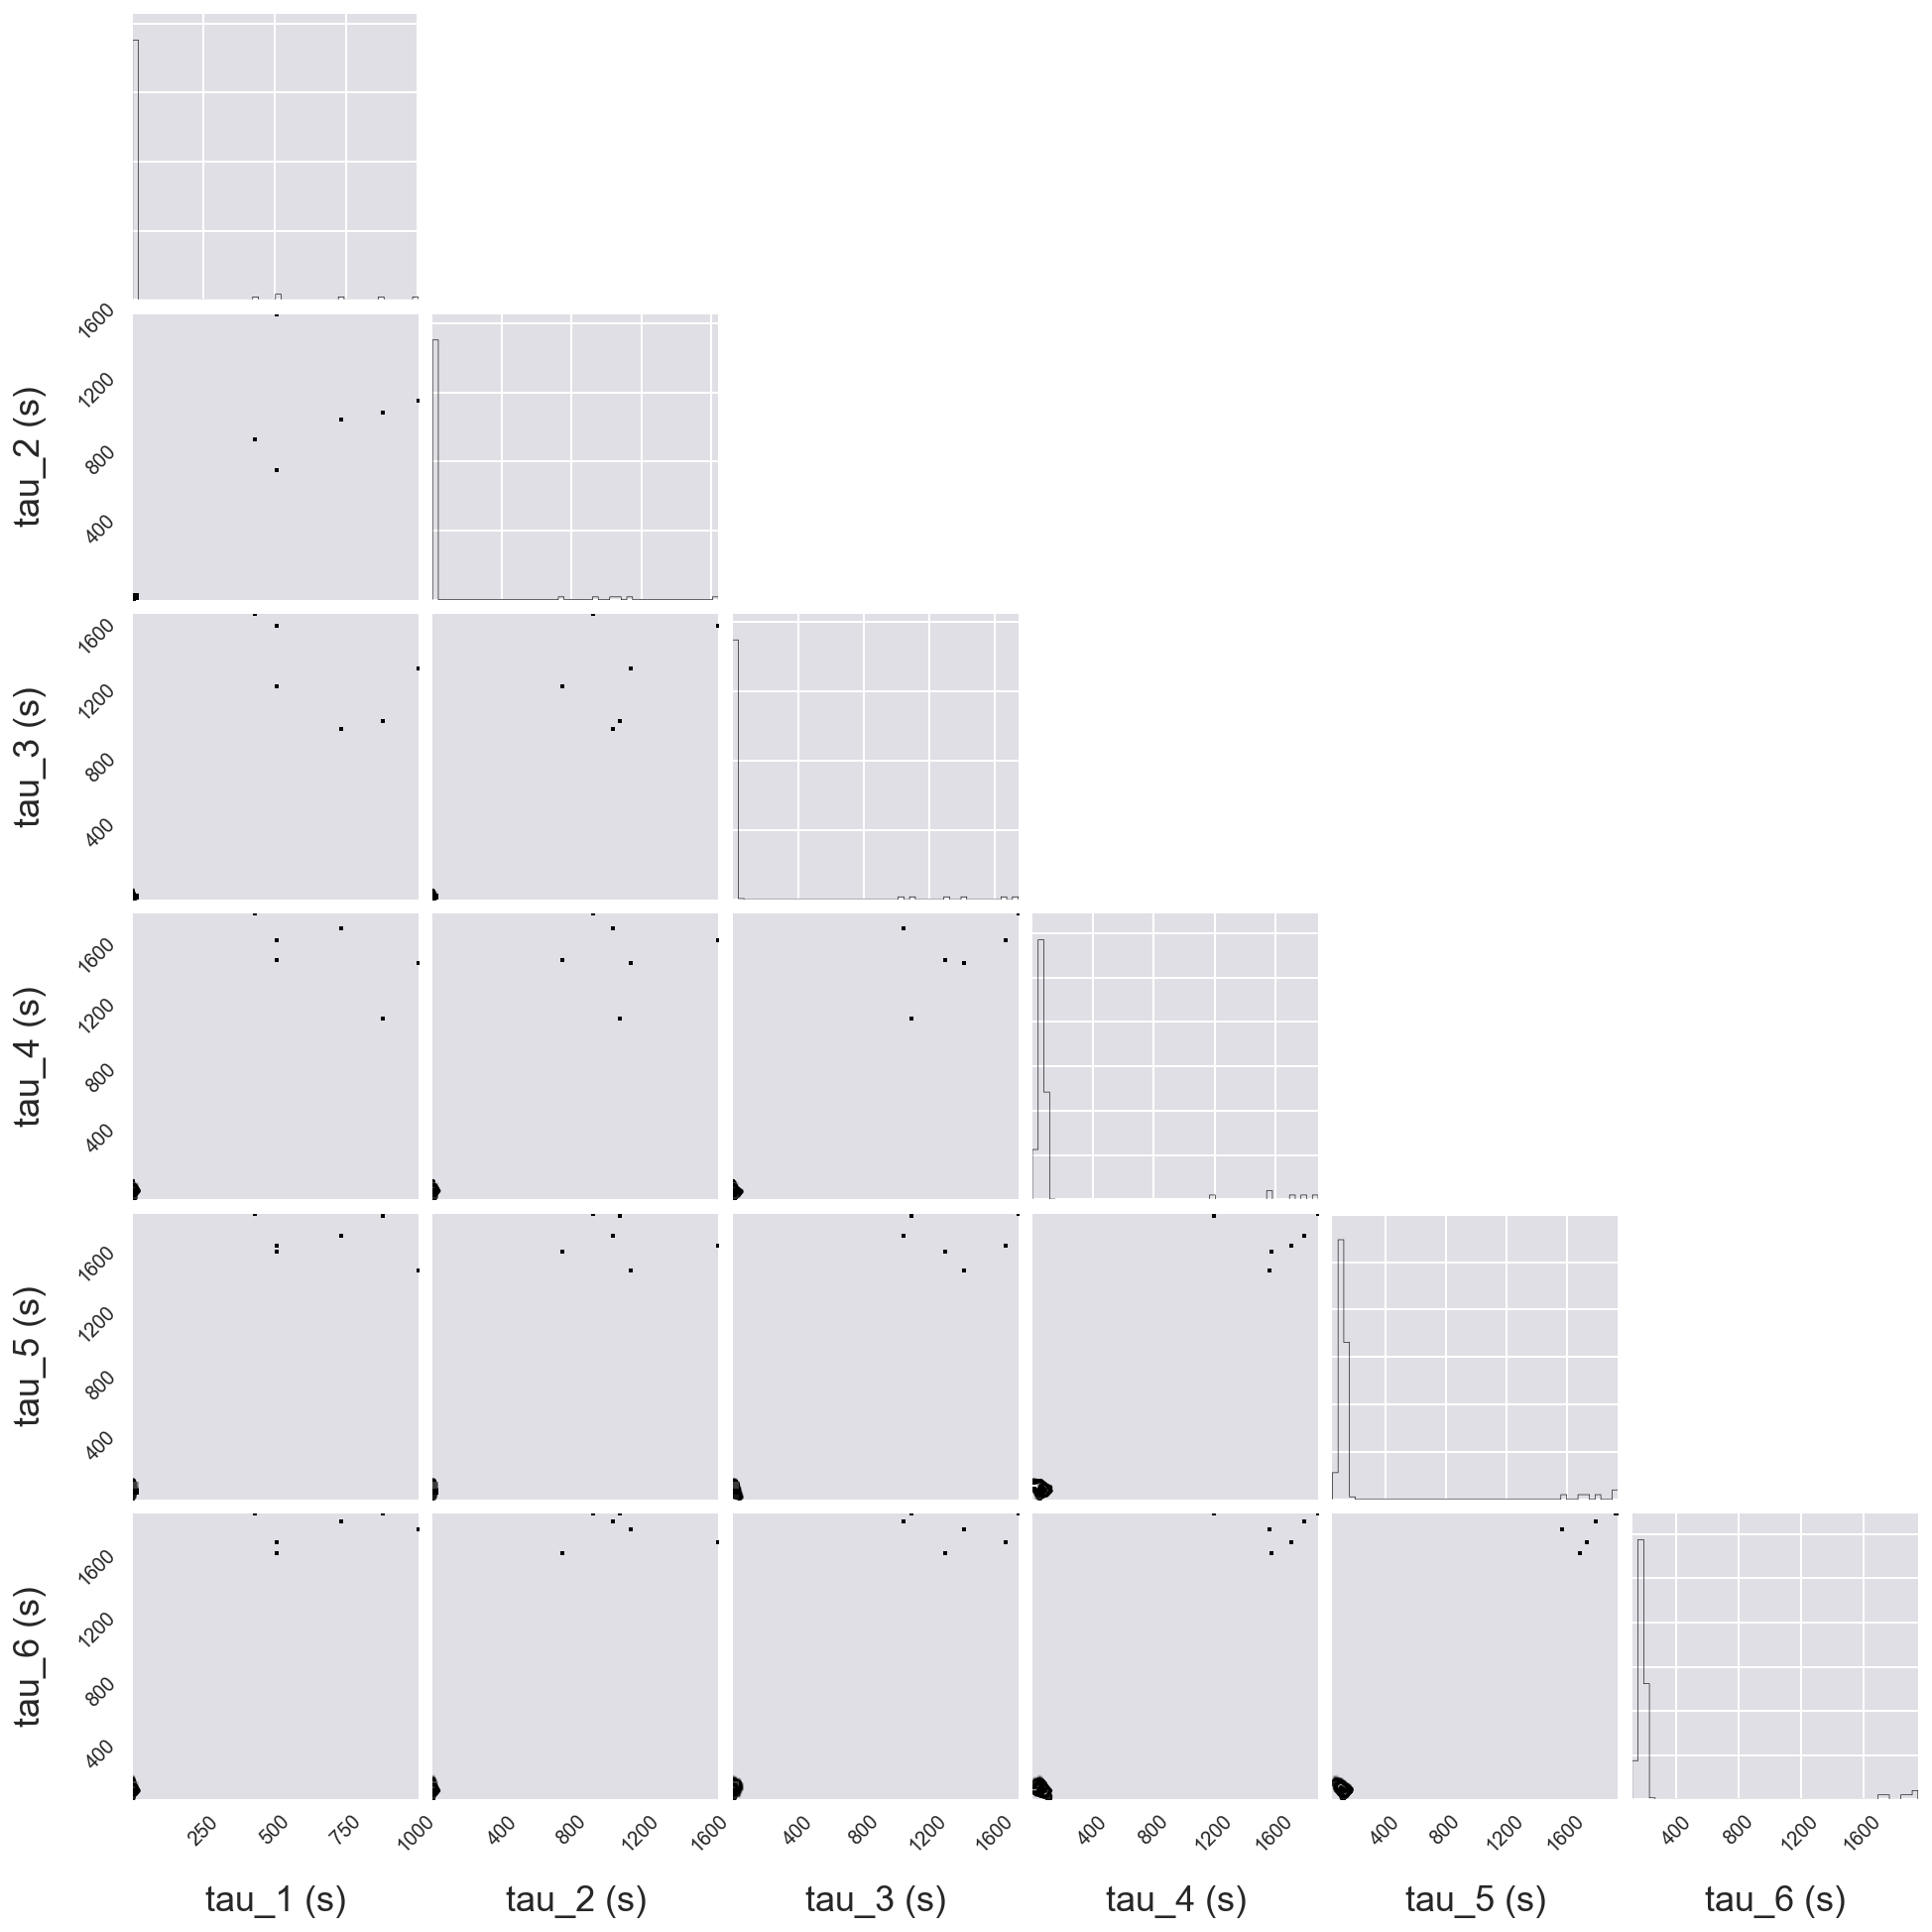

In [43]:
m = 6
df_ = results[m]['df'][results[m]['df'].beta_ind==0].filter(regex='tau')
corner.corner(df_, bins=50);

<br />
<br />

### Problem 6.2: Spike sorting, 30 pts

Dawna and Kyu kindly provided us with another set of voltage measurements from a mouse retina.  You can download the data [here](../data/H930start2filt.txt.zip).  These data have been pre-filtered, so you do not need to do any filtering, unless you think it will help your analysis.  For this trace:

**a)** Locate all spikes.

**b)** There are two types of spikes.  Devise a way to automatically tell the difference between each type of spike.  Plot all of the spikes overlayed on top of each other with their minima at the same point.  The plot should be color-coded so that two classes of spikes have different colors.

**c)** Plot the probability distributions of inter-spike times for each type of spike and comment on anything you see of note.

### Problem 6.2: solution
**a)** We start by loading in the data set and converting to NumPy arrays for faster indexing.

In [ ]:
df = pd.read_csv('../data/bagherian_et_al/H930start2filt.txt', sep='\t',
                 comment='#', header=None, names=['time (ms)', 'V (µV)'])

t = df['time (ms)'].values
V = df['V (µV)'].values

Now, let's take a look at the signal.

In [ ]:
plt.plot(t, V, '-')
plt.xlabel('time (ms)')
plt.ylabel('V (µV)')

There appear to be two types of spikes, a deep one and a shallow one.  This is easier seen with Bokeh.

In [ ]:
p = bokeh.charts.Line(df.loc[10000:30000,:], x='time (ms)', y='V (µV)', 
                      color='slateblue')
bokeh.io.show(p)

In zooming around the above plot, we can see to spikes between 2.70 and 2.73 seconds.

In [ ]:
inds = (df['time (ms)'] > 2700) & (df['time (ms)'] < 2730)
p = bokeh.charts.Line(df.loc[inds,:], x='time (ms)', y='V (µV)', 
                      color='slateblue')
bokeh.io.show(p)

From the first plot, it appears as though all spikes cross a threshold of -60 µV, so we will identify spikes by downward crossings of -60 µV.

In [ ]:
thresh = -60  # µV

# Find indices of downward crossings
crossing_inds = np.where(np.logical_and(V[:-1] > thresh, V[1:] < thresh))[0] + 1

# How many spikes?
print(len(crossing_inds), 'spikes')

In [ ]:
plt.plot(np.diff(crossing_inds))

In [ ]:
i = 0
for i in range(max(len(down), len(up))):
    r = [down[i] - 10, up[i]+10]
    plt.plot(V[r[0]:r[1]], 'k-', lw=0.2)

In [ ]:
plt.plot(t, V, '-')
plt.plot(t[down+1], V[down+1], 'r.')